## Fine Tuning of Bart large MNLI

In [177]:
import pandas as pd
from datasets import Dataset
import torch
from transformers import BartTokenizer


## Train

In [178]:
# Load your DataFrame
df = pd.read_csv("./datasets/bart_data.csv")  # or use your in-memory df
df = df.drop(columns=["Unnamed: 0"], errors="ignore")  # safe even if not present

# Map labels to integers
label2id = {"contradiction": 0, "neutral": 1, "entailment": 2}
df['label'] = df['label'].map(label2id)

# Rename columns for consistency with HuggingFace
df = df.rename(columns={"claim": "premise", "original_question": "hypothesis"})

# Convert to HuggingFace dataset
train_dataset = Dataset.from_pandas(df)


In [179]:
train_dataset

Dataset({
    features: ['hypothesis', 'premise', 'label'],
    num_rows: 1787
})

GPU Check

In [180]:
torch.cuda.is_available()

True

In [181]:
# Load your DataFrame
val_df = pd.read_csv("./datasets/bart_val_data.csv")  # or use your in-memory df
val_df = val_df.drop(columns=["Unnamed: 0"], errors="ignore")  # safe even if not present

# Map labels to integers
label2id = {"contradiction": 0, "neutral": 1, "entailment": 2}
val_df['label'] = val_df['label'].map(label2id)

# Rename columns for consistency with HuggingFace
val_df = val_df.rename(columns={"claim": "premise", "original_question": "hypothesis"})

# Convert to HuggingFace dataset
val_dataset = Dataset.from_pandas(val_df)

In [182]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")

def tokenize(example):
    return tokenizer(
        example["premise"],
        example["hypothesis"],
        truncation=True,
        padding="max_length",
        max_length=100
    )

# Apply tokenizer
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Format both datasets for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map: 100%|██████████| 375/375 [00:00<00:00, 1082.35 examples/s]


Text percentile check to save vram space during training by checking sentence length distributions

In [183]:
import numpy as np
lengths = [len(tokenizer(p, h)['input_ids']) for p, h in zip(df['premise'], df['hypothesis'])]
print(np.percentile(lengths, [50, 75, 90, 95, 99]))


lengths = [len(tokenizer(p, h)['input_ids']) for p, h in zip(val_df['premise'], val_df['hypothesis'])]
print(np.percentile(lengths, [50, 75, 90, 95, 99]))

[39. 42. 45. 47. 51.]
[40.   43.   47.   50.   56.52]


In [184]:
from transformers import BartForSequenceClassification


model = BartForSequenceClassification.from_pretrained(
    "facebook/bart-large-mnli",
    num_labels=3,
    label2id={"contradiction": 0, "neutral": 1, "entailment": 2},
    id2label={0: "contradiction", 1: "neutral", 2: "entailment"}
)


In [185]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)

    # average='macro' gives equal weight to each class
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [187]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./bart-nli-finetuned",
    save_strategy="epoch",
    per_device_train_batch_size=3,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=2e-5,  # or even 3e-5
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    eval_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # optional here
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\awsy2\AppData\Local\Temp\ipykernel_35168\81068456.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [188]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.302300,1.023927,0.797333,0.778714,0.787299,0.778495
2,0.000700,1.332166,0.821333,0.840573,0.760189,0.773998
3,0.004200,1.161365,0.848000,0.821855,0.812495,0.816129
4,0.000200,1.145824,0.845333,0.833179,0.806035,0.814454
5,0.000100,1.137919,0.848000,0.834745,0.801781,0.811362


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight'].


TrainOutput(global_step=2980, training_loss=0.25746208911924934, metrics={'train_runtime': 1008.3091, 'train_samples_per_second': 8.861, 'train_steps_per_second': 2.955, 'total_flos': 1896569134803000.0, 'train_loss': 0.25746208911924934, 'epoch': 5.0})

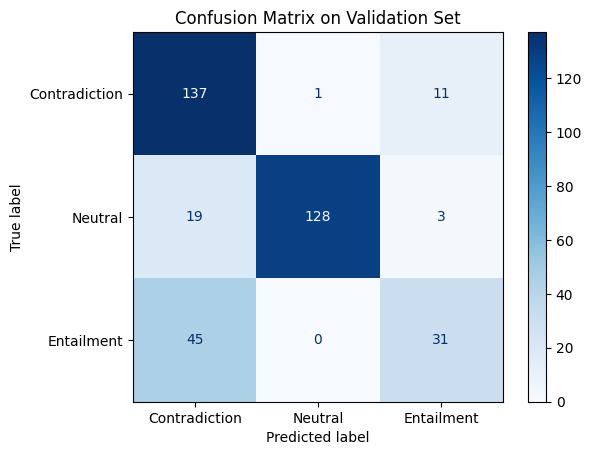

In [174]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Extract predictions from trainer
preds_output = trainer.predict(val_dataset)

# If predictions is a tuple (common), get the first element
logits = preds_output.predictions
if isinstance(logits, tuple):
    logits = logits[0]

# Now compute predicted labels
preds = np.argmax(logits, axis=-1)
labels = preds_output.label_ids

# Confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Contradiction', 'Neutral', 'Entailment'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.show()


In [175]:
# Get predictions
preds_output = trainer.predict(val_dataset)
logits = preds_output.predictions
if isinstance(logits, tuple):
    logits = logits[0]
preds = np.argmax(logits, axis=-1)
labels = preds_output.label_ids

# Get the original text fields from val_dataset
# Assuming val_dataset was a HuggingFace Dataset and still has the original columns
premises = val_dataset['premise']
hypotheses = val_dataset['hypothesis']

# Convert label IDs to text if needed
id2label = {0: "contradiction", 1: "neutral", 2: "entailment"}
label_texts = [id2label[i] for i in labels]
pred_texts = [id2label[i] for i in preds]

# Create DataFrame
df_preds = pd.DataFrame({
    'premise': premises,
    'hypothesis': hypotheses,
    'true_label': label_texts,
    'predicted_label': pred_texts
})

# Show it
df_preds.head()

,premise,hypothesis,true_label,predicted_label
0,A study published in 2024 indicated that the global average life expectancy dropped to 71.8 years.,Was the average global life expectancy 73.4 years in 2024?,contradiction,contradiction
1,"By mid-2024, the international student population in Canada was estimated to be around 910,000.","Did the number of international students in Canada surpass 900,000 in 2024?",entailment,contradiction
2,"By early 2024, over 250 million COVID-19 vaccine doses had been administered across Africa.",Were more than 230 million COVID-19 vaccine doses administered in Africa by 2024?,entailment,contradiction
3,"In 2022, the average hospital stay in the U.S. was 5.1 days, indicating a slight decline.",Was the average hospital stay in the U.S. reduced to 4.8 days in 2023?,neutral,contradiction
4,Research shows that the increase in average sea level from 1993 to 2023 is around 98 millimeters.,Was the average sea level 98 millimeters higher in 2023 compared to 1993?,entailment,entailment


In [176]:
pd.set_option('display.max_colwidth', None)
df_preds[df_preds['true_label'] != df_preds['predicted_label']]

,premise,hypothesis,true_label,predicted_label
1,"By mid-2024, the international student population in Canada was estimated to be around 910,000.","Did the number of international students in Canada surpass 900,000 in 2024?",entailment,contradiction
2,"By early 2024, over 250 million COVID-19 vaccine doses had been administered across Africa.",Were more than 230 million COVID-19 vaccine doses administered in Africa by 2024?,entailment,contradiction
3,"In 2022, the average hospital stay in the U.S. was 5.1 days, indicating a slight decline.",Was the average hospital stay in the U.S. reduced to 4.8 days in 2023?,neutral,contradiction
7,"According to recent statistics, South Korea's average internet speed reached 100 Mbps exactly in 2024.",Did the average internet speed in South Korea exceed 100 Mbps in 2024?,entailment,contradiction
19,"By the end of 2023, the U.S. population was estimated to be about 337 million.",Was the population of the United States approximately 334 million in 2023?,contradiction,entailment
...,...,...,...,...
352,"In Q4 2023, Apple reported a significant increase in iPhone sales compared to the previous quarter.",Did Apple sell more than 85 million iPhones globally in Q4 2023?,neutral,contradiction
357,Research found that the average daily screen time for teenagers in urban areas was 7 hours and 15 minutes.,Was the average daily screen time for teenagers above 7 hours in 2023?,neutral,contradiction
366,"By the end of 2024, South Korea's average internet speed was recorded at 101 Mbps, exceeding 100 Mbps.",Did the average internet speed in South Korea exceed 100 Mbps in 2024?,contradiction,entailment
368,"The S&P 500 index closed at 4,850 points on December 31, 2024.","Did the S&P 500 index close above 4,800 points at the end of 2024?",entailment,contradiction


In [149]:
import gc
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
gc.collect()
del model
del tokenizer